In [36]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

# Fonctions

In [58]:
def ReLu(x):
    # if (x < 0):
    #     return 0
    # return x
    return np.maximum(0,x)

def softmax(x):
    sum = 0
    for i in range(len(x)):
        sum += np.exp(x[i])
    return np.exp(x) / sum


# def Max3x3(M): // a adapter car pour le moment j'utilise  np.max ca fait le taff
#     max = M[0][0]
#     for i in range(3):
#         for j in range(3):
#             if M[i][j] > max:
#                 max = M[i][j]
#     return max

def MaxPool(M):
    y,x,num_channels = M.shape
    i = 0
    j = 0
    output_height = (y - 3) // 2 + 1
    output_width = (x - 3) // 2 + 1
    print(f"output height: {output_height}, output width: {output_width}")
    output = np.zeros((output_height, output_width, num_channels))

    for c in range(num_channels):
        for i in range(0, output_height):
            for j in range(0, output_width):
                start_i, start_j = i * 2, j * 2
                region = M[start_i:start_i + 3, start_j:start_j + 3, c] #j'ai enlever output x et y car pas besoin et re for pour eviter de remettre à 0
                output[i, j, c] = np.max(region)
    return output

def MaxPool_v2(M):
    y,x,num_channels = M.shape
    i = 0
    j = 0
    output_height = y // 2
    output_width = x // 2
    output = np.zeros((output_height, output_width, num_channels))
    for c in range(num_channels):
        for i in range(0, output_height):
            for j in range(0, output_width):
                start_i, start_j = i * 2, j * 2
                if (start_i + 3 > y):
                    if(start_j + 3 > x):
                        region = M[start_i:y, start_j:start_j + 3, c]
                    else:
                        region = M[start_i:y, start_j:x, c]
                elif (start_j + 3 > x):
                    region = M[start_i:start_i + 3, start_j:x, c]
                else:
                    region = M[start_i:start_i + 3, start_j:start_j + 3, c] #j'ai enlever output x et y car pas besoin et re for pour eviter de remettre à 0
                output[i, j, c] = np.max(region)
    return output

def convolution(image, Ks, biais):
    image_height, image_width, image_channels = image.shape
    K_height, K_width, _, num_filters,= Ks.shape
    output_height = image_height
    output_width = image_width
    output = np.zeros((output_height, output_width, num_filters))
    padded_image = np.pad(image, ((2, 2), (2, 2), (0, 0)), mode='constant') #j'ai vu qu'il fallait faire du padding pour conserver les dimensions de notre frame 3D 
   
    for f in range(num_filters):
        conv_sum = np.zeros((output_height, output_width))
        for c in range(image_channels):  
            for i in range(output_height):
                for j in range(output_width):
                    region = padded_image[i:i+K_height, j:j+K_width, c]
                    conv_sum[i, j] += np.sum(region * Ks[:, :, c, f])
        output[:, :, f] = ReLu(conv_sum + biais[f])
   
    return output

def c_reshape(M):
    height, width, channels = M.shape
    output = M
    return output.reshape(height*width*channels) # On garde comme ça pour l'instant mais à changer pour le matériel

def FCP(M, weights, bias): # Fully Connected Perceptron
    '''
    M : (180,)
    weights : (180, 10)
    bias : (10,)
    output : (10,)
    '''
    M = M.T
    output = softmax(M.dot(weights) + bias)
    return output

def normalize(M):
    min_val = np.min(M)
    max_val = np.max(M)
    
    M_normalized = (M - min_val) / (max_val - min_val)
    
    return M_normalized

def normalize_image(I):
    N = I.size
    mu = np.mean(I)
    sigma = np.std(I)

    normalized = (I - mu) / max(sigma, 1 / np.sqrt(N))

    return normalized


# IMAGES

(24, 24, 3)


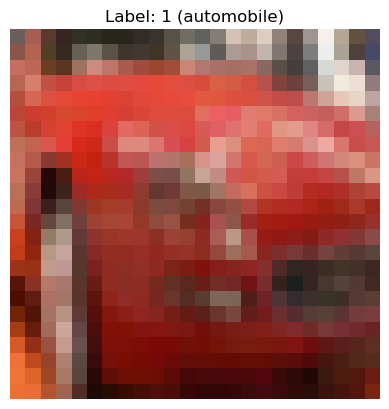

In [80]:
def load_cifar10_batch(file_path):
    with open(file_path, 'rb') as file:
        # Each image is 3073 bytes (1 label + 3072 pixel values)
        data = np.frombuffer(file.read(), dtype=np.uint8)
        
    # Reshape to 10000 rows of 3073 bytes
    data = data.reshape(-1, 3073)
    
    # First column is labels, rest are pixel values
    labels = data[:, 0]
    images = data[:, 1:]
    
    # Reshape image data: 3072 pixels -> 3 channels (32x32)
    images = images.reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1)  # Shape (10000, 32, 32, 3)
    
    resized_images = np.array([image[4:28, 4:28] for image in images])
    
    return resized_images, labels

def load_class_names(file_path):
    with open(file_path, 'r') as file:
        class_names = [line.strip() for line in file]
    return class_names


def plot_sample_image(images, labels, class_names, index=0):
    # Select image and label at the given index
    image = images[index]
    label = labels[index]
    class_name = class_names[label]

    print(image.shape)
    
    # Plot the image
    plt.imshow(image)
    plt.title(f"Label: {label} ({class_name})")
    plt.axis('off')
    plt.show()

# Usage:
images, labels = load_cifar10_batch('../../Downloads/cifar10_data/cifar-10-batches-bin/data_batch_1.bin')
class_names = load_class_names('../../Downloads/cifar10_data/cifar-10-batches-bin/batches.meta.txt')

plot_sample_image(images, labels, class_names, index=5)

# TEST SUR IMAGE

In [ ]:
def process_tensor_data(tensor_name, raw_data):
    cleaned_string = raw_data.replace('[', '').replace(']', '').replace('\n', ' ')
    float_list = [float(x) for x in cleaned_string.split()]
    tensor_dict[tensor_name] = np.array(float_list)

tensor_dict = {}

with open('../../Downloads/CNN_coeff_3x3.txt', 'r') as file:
    tensor_name = None
    raw_data = ''
    
    for line in file:
        if line.startswith('tensor_name:'):
            if tensor_name:
                process_tensor_data(tensor_name, raw_data)
            tensor_name = line.split(':')[1].strip()
            raw_data = ''
        else:
            raw_data += line.strip() + '\n'
    
    if tensor_name:
        process_tensor_data(tensor_name, raw_data)

def reshape_array_parameters():
    for tensor_name, parameter_array in tensor_dict.items():
        if tensor_name == 'conv1/biases':
            tensor_dict[tensor_name] = parameter_array.reshape(64,)
        elif tensor_name == 'conv1/weights':
            tensor_dict[tensor_name] = parameter_array.reshape(3, 3, 3, 64)
        elif tensor_name == 'conv2/biases':
            tensor_dict[tensor_name] = parameter_array.reshape(32,)
        elif tensor_name == 'conv2/weights':
            tensor_dict[tensor_name] = parameter_array.reshape(3, 3, 64, 32)
        elif tensor_name == 'conv3/biases':
            tensor_dict[tensor_name] = parameter_array.reshape(20,)
        elif tensor_name == 'conv3/weights':
            tensor_dict[tensor_name] = parameter_array.reshape(3, 3, 32, 20)
        elif tensor_name == 'local3/biases':
            tensor_dict[tensor_name] = parameter_array.reshape(10,)
        elif tensor_name == 'local3/weights':
            tensor_dict[tensor_name] = parameter_array.reshape(180, 10)

reshape_array_parameters()

In [56]:
tensor_dict['local3/biases']

array([ 1.33150375, -0.05496363,  1.30825186,  2.52893686,  1.00788128,
        2.28100443,  1.75292468,  1.02082717,  0.45848575,  0.17053629])

In [82]:
input_image = images[5]
input_image = normalize_image(input_image)
k1 = tensor_dict['conv1/weights']
biais1 = tensor_dict['conv1/biases']
k2 = tensor_dict['conv2/weights']
biais2 = tensor_dict['conv2/biases']
k3 = tensor_dict['conv3/weights']
biais3 = tensor_dict['conv3/biases']
weights_fcp = tensor_dict['local3/weights']
biais_fcp = tensor_dict['local3/biases']

conv1 = convolution(input_image, k1, biais1)
maxpool1 = MaxPool_v2(conv1)
conv2 = convolution(maxpool1, k2, biais2)
maxpool2 = MaxPool_v2(conv2)
conv3 = convolution(maxpool2, k3, biais3)
maxpool3 = MaxPool_v2(conv3)
reshape = c_reshape(maxpool3)
output = FCP(reshape, weights_fcp, biais_fcp)
print(output)
np.sum(output)
index_max = np.argmax(output)
print(index_max)
class_names[index_max]

[2.83625288e-04 9.72199457e-01 2.40845732e-05 2.05424540e-04
 4.46224817e-04 1.92343374e-04 6.26408278e-05 3.66050027e-03
 1.45930786e-04 2.27797682e-02]
1


'automobile'

In [79]:
class_names[6]

'frog'

# Modèle Complet de test

In [ ]:
input_image = np.random.rand(24, 24, 3)
k1 = np.random.rand(3, 3, 3, 64)
biais1 = np.random.rand(64)
k2 = np.random.rand(3, 3, 64, 32)
biais2 = np.random.rand(32)
k3 = np.random.rand(3, 3, 32, 20)
biais3 = np.random.rand(20)
weights_fcp = np.random.rand(180, 10)
biais_fcp = np.random.rand(10,)

conv1 = convolution(input_image, k1, biais1)
maxpool1 = MaxPool_v2(conv1)
conv2 = convolution(maxpool1, k2, biais2)
maxpool2 = MaxPool_v2(conv2)
conv3 = convolution(maxpool2, k3, biais3)
maxpool3 = MaxPool_v2(conv3)
norm1=normalize(maxpool3)#je l'ai fait de manière un peu vener mais ça marche
reshape = c_reshape(norm1)
output = FCP(reshape, weights_fcp, biais_fcp)
print(output)
np.sum(output)
# PROBLEME AVEC EXPONENTIELLE... peut etre qu'avec les parametres du profs + en normalisant comme on devra le faire on aura pas ces problemes mais je ne suis pas sur

[5.16191732e-02 7.45023220e-03 2.34179300e-04 1.33853087e-01
 1.15099113e-04 5.57206988e-01 6.08066200e-03 1.36721093e-01
 3.73450576e-02 6.93744283e-02]


1.0

# Tests

In [40]:
input_image = np.random.rand(3, 3, 20)
weights = np.random.rand(180, 10)
biais1 = np.random.rand(10,)

reshape = c_reshape(input_image)
output = FCP(reshape, weights, biais1)
print("Reshape ", reshape.shape)
print("output ", output.shape)
output

Reshape  (180,)
output  (10,)


array([2.20170380e-03, 4.67058942e-01, 7.38930578e-03, 1.28046624e-04,
       1.95621841e-03, 6.18633527e-05, 4.32034240e-01, 6.14900538e-02,
       2.69413156e-02, 7.38310749e-04])

In [41]:

matrice = np.random.randint(0, 256, size=(24, 24, 3))

R = matrice[:, :, 0]
G = matrice[:, :, 1]
B = matrice[:, :, 2]

# print("Canal Rouge (R):")
# print(R)
# print("\nCanal Vert (G):")
# print(G)
# print("\nCanal Bleu (B):")
# print(B)


In [42]:
m2=MaxPool(matrice)
R2 = m2[:, :, 0]
G2 = m2[:, :, 1]
B2 = m2[:, :, 2]

# print("Canal Rouge (R):")
# print(R2)
# print("\nCanal Vert (G):")
# print(G2)
# print("\nCanal Bleu (B):")
# print(B2)

output height: 11, output width: 11


In [43]:
input_image = np.random.rand(24, 24, 3)
k1 = np.random.rand(64, 3, 3, 3)  # 64 filtres de 3x3x3
biais1 = np.random.rand(64)

conv1_output = convolution(input_image, k1, biais1)
maxpool_output = MaxPool_v2(conv1_output)
print("Convolution 1 ", conv1_output.shape)  # (24, 24, 64)
print("Maxpool 1 ", maxpool_output.shape)  # (3, 3, 20)

Convolution 1  (24, 24, 64)
Maxpool 1  (12, 12, 64)
